In [1]:
# Import necessary libraries for preprocessing
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge, ElasticNet

# Load the dataset
#Atlanta_Distance = pd.read_pickle(r'~/Documents/NYCDSA/Capstone/Pickle Files/Atlanta_Nearest_POI.pkl')
Atlanta_Distance = pd.read_csv('~/Documents/NYCDSA/Capstone/Nearest_Distances_Atlanta/Atlanta_Nearest_Distances.csv')
Atlanta_Distance['Total Bathrooms'] = Atlanta_Distance['number_of_full_baths'] + (Atlanta_Distance['number_of_half_baths']*0.5)
Atlanta_Distance = Atlanta_Distance.drop(columns=['ID', 'year_built', 'source_name',
                                                  'listing_date', 'mls_id', 'census_zcta5_geoid',
                                                  'census_cbsa_geoid', 'latitude', 'longitude', 'lot_size_in_acres', 'number_of_full_baths', 'number_of_half_baths'])
Atlanta_Distance = Atlanta_Distance.rename(columns={'Distance_SM': 'Supermarket', 'Distance_C': 'Convenience',
'Distance_WS': 'Wholesale', 'Distance_VS': 'Variety Store', 'Distance_SC': 'Supercenter', 'number_of_bedrooms': 'Total Bedrooms', 'living_area_square_feet': 'Living Area(SQF)',
                                                   'lot_size_in_square_feet': 'Lot Size(SQF)', 'number_of_garage_spaces': 'Garage Spaces', 'number_of_stories': 'Stories'})
Atlanta_Distance

,street_address,city,state,current_listing_price,Total Bedrooms,Living Area(SQF),Lot Size(SQF),has_pool,has_garage,Garage Spaces,...,Supercenter,Convenience_POI,Convenience,Supermarket_POI,Supermarket,Variety_store_POI,Variety Store,Wholesale_POI,Wholesale,Total Bathrooms
0,0 ivy MNR DR NW 0,Marietta,GA,2865,4,3259.0,14810.400390,False,True,NaN,...,2539.28,Sunoco,2715.74,Kroger,1654.08,Bargain Hunt,6405.99,Atlanta Wholesale,10917.45,2.5
1,1 10 buena VIS CIR SE,Cartersville,GA,2200,3,1993.0,NaN,False,False,NaN,...,492.63,Mack's Express,1407.26,Publix,3065.55,Dollar Tree,405.11,LI Global Liquidation,32739.68,2.0
2,1 1088 coldwater DR,Griffin,GA,2000,3,1910.0,NaN,False,True,NaN,...,25413.80,Unnamed POI,3213.19,Kroger,3780.13,Dollar General,4738.04,Costco,29267.11,2.0
3,1 1130 willivee DR,Decatur,GA,1995,3,1134.0,NaN,False,False,NaN,...,7857.71,Food Mart,2385.60,Publix,2320.59,Dollar Tree,4356.55,Sam's Club,9020.53,1.0
4,1 1307 idlewood CT,Mcdonough,GA,2800,4,2532.0,NaN,False,True,NaN,...,11676.91,Crossings at McDonough,14263.22,Kroger,5625.35,Dollar Tree,6721.22,Costco,14750.79,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21025,procurement only - 66 4th ST,Newnan,GA,1600,3,1367.0,NaN,False,True,NaN,...,19852.16,Newnan Lakes Chevron,4983.93,Little Giant Supermaket,2097.35,Family Dollar,6409.21,Two Valleys Distribution,47285.12,2.0
21026,r2188 executive DR,Duluth,GA,2199,3,1696.0,871.199981,False,False,NaN,...,4864.86,Unnamed POI,1477.04,Mega Mart,888.22,Dollar Tree,6142.54,Sam's Club,2009.36,2.5
21027,r3339 woodward down,Buford,GA,2380,3,1944.0,4356.000065,False,False,NaN,...,1359.41,Walgreens,3952.51,ALDI,1158.08,Five Below,714.63,Sam's Club,1507.23,3.5
21028,singleunit 216 greensprings DR,Palmetto,GA,1900,4,1204.0,NaN,False,False,NaN,...,10787.35,Flash Foods,1242.13,Publix,8779.81,Family Dollar,1402.52,Costco,40632.51,2.0


In [2]:
# Exclude 'current_listing_price' from features
numeric_features = Atlanta_Distance.select_dtypes(include=['int64', 'float64']).drop(columns=['current_listing_price']).columns
#categorical_features = list(Atlanta_Distance.columns[Atlanta_Distance.dtypes == 'object'])

In [3]:
# Helper function to fill 'None' for missing categorical data
def fill_none(X):
    return X.fillna("None")

# Pipeline for numeric features: Impute missing values using mean
numeric_transformer = Pipeline(steps=[
    ('impute_mean', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Pipeline for nominal categorical features: Fill missing values with 'None' then apply one-hot encoding
#categorical_transformer = Pipeline(steps=[
    #('impute_none', SimpleImputer(strategy='constant', fill_value='None')),  # Using SimpleImputer
    #('onehot', OneHotEncoder(handle_unknown='ignore'))
#])

# Combined preprocessor for numeric and nominal
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        #('nominal', categorical_transformer, categorical_features)
])

transformed_data = preprocessor.fit_transform(Atlanta_Distance)

In [4]:
# Generate column names for the one-hot encoded features
#onehot_features = preprocessor.named_transformers_['nominal'].named_steps['onehot'].get_feature_names_out()
# Combine all feature names
all_feature_names = list(numeric_features)
all_feature_names

['Total Bedrooms',
 'Living Area(SQF)',
 'Lot Size(SQF)',
 'Garage Spaces',
 'Stories',
 'Supercenter',
 'Convenience',
 'Supermarket',
 'Variety Store',
 'Wholesale',
 'Total Bathrooms']

In [5]:
transformed_df = pd.DataFrame(transformed_data, columns=all_feature_names)
#transformed_df

In [6]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

# Target variable
y = Atlanta_Distance['current_listing_price']
# All features
X = Atlanta_Distance.drop(columns='current_listing_price')
models = LinearRegression()

coefficients_list = []
intercepts_list = []
scores = []
# Perform the KFold cross-validation
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', models),
])
# Initialize the linear regression model
# Fit the model on the training data
pipeline.fit(Atlanta_Distance.drop(columns='current_listing_price'), Atlanta_Distance['current_listing_price'])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Total Bedrooms', 'Living Area(SQF)', 'Lot Size(SQF)', 'Garage Spaces',
       'Stories', 'Supercenter', 'Convenience', 'Supermarket', 'Variety Store',
       'Wholesale', 'Total Bathrooms'],
      dtype='object'))])),
                ('regressor', LinearRegression())])

In [7]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
scores = cross_val_score(pipeline, Atlanta_Distance.drop(columns='current_listing_price'), Atlanta_Distance['current_listing_price'], scoring = 'r2', cv=kf, n_jobs = -1)

In [8]:
scores

array([ 0.18560202,  0.24106086,  0.13796858,  0.27779826,  0.28832131,
        0.29136132,  0.32350046,  0.30391784, -6.00188973,  0.25457043])

In [9]:
# Find the best score (maximum R^2 score)
best_score = scores.max()

print("Best R^2 score from cross-validation:", best_score)
print('Variance:',np.var(scores))

Best R^2 score from cross-validation: 0.3235004554602312
Variance: 3.527392717079801


In [10]:
coefficients = results.params
print(coefficients)

NameError: name 'results' is not defined

In [11]:
fold_scores = []
fold_num = 1
for train_index, test_index in kf.split(Atlanta_Distance):
    X_train, X_test = Atlanta_Distance.drop(columns='current_listing_price').iloc[train_index],Atlanta_Distance.drop(columns='current_listing_price').iloc[test_index]
    y_train, y_test = Atlanta_Distance['current_listing_price'].iloc[train_index], Atlanta_Distance['current_listing_price'].iloc[test_index]
    pipeline.fit(X_train, y_train)
    fold_score = pipeline.score(X_test, y_test)
    print(f'Score for Fold: {fold_num}', fold_score)
    fold_scores.append({
        'score':fold_score,
        'fold':fold_num})
    fold_num += 1

Score for Fold: 1 0.18560201804748944
Score for Fold: 2 0.24106086271717042
Score for Fold: 3 0.13796857770681592
Score for Fold: 4 0.2777982604721627
Score for Fold: 5 0.2883213069884982
Score for Fold: 6 0.29136131559861
Score for Fold: 7 0.3235004554602312
Score for Fold: 8 0.3039178408793758
Score for Fold: 9 -6.001889729649638
Score for Fold: 10 0.2545704277900591


In [12]:
from sklearn.metrics import mean_squared_error, r2_score, PredictionErrorDisplay
rmse_scores = []
r2_scores = []
coefs_per_fold = []

all_y_pred = []
all_y_actual = []
residuals = []

y = Atlanta_Distance['current_listing_price']


results_list = []

X = Atlanta_Distance.drop(columns='current_listing_price')

# cat_cols = [col for col in X.columns if X[col].dtype == 'object']

# if cat_cols:
#     encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
#     transformed_X = encoder.fit_transform(X[cat_cols])
#     transformed_X = pd.DataFrame(transformed_X.toarray(), columns=encoder.get_feature_names_out())
#     transformed_X.reset_index(drop=True, inplace=True)
#     X.reset_index(drop=True, inplace=True)
#     X = pd.concat([X.drop(columns=cat_cols), transformed_X], axis=1)

kf = KFold(n_splits = 10, shuffle = False)

for fold, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]        

    lm = pipeline
    lm.fit(X_train, y_train)

    coefs_per_fold.append(lm['regressor'].coef_)

    y_pred = lm.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    
    all_y_pred.extend(y_pred)
    all_y_actual.extend(y_test.values)
    residuals.extend(y_test.values - y_pred)
    
    print(f"Fold {fold+1}: RMSE = {round(rmse, 4)}, R2 = {round(r2, 4)}")

mean_rmse = np.mean(rmse_scores)
mean_r2 = np.mean(r2_scores)

print(f"Average RMSE: {round(mean_rmse, 4)}")
print(f"Std of RMSE: {round(np.std(rmse_scores), 4)}")
print(f"Average R2: {round(mean_r2, 4)}")
print(f"Std of R2: {round(np.std(r2_scores), 4)}")

Fold 1: RMSE = 908.406, R2 = 0.1856
Fold 2: RMSE = 853.5381, R2 = 0.2411
Fold 3: RMSE = 848.3452, R2 = 0.138
Fold 4: RMSE = 706.7168, R2 = 0.2778
Fold 5: RMSE = 685.1724, R2 = 0.2883
Fold 6: RMSE = 798.8015, R2 = 0.2914
Fold 7: RMSE = 714.0868, R2 = 0.3235
Fold 8: RMSE = 715.7332, R2 = 0.3039
Fold 9: RMSE = 2267.9437, R2 = -6.0019
Fold 10: RMSE = 860.3167, R2 = 0.2546
Average RMSE: 935.906
Std of RMSE: 450.2353
Average R2: -0.3698
Std of R2: 1.8781


In [23]:
data = [['F1', 0.1933, 0.19], 
        ['F2', 0.2486, 0.25], 
        ['F3', 0.1487, 0.15], 
        ['F4', 0.2855, 0.29], 
        ['F5', 0.2862, 0.29],
        ['F6', 0.2984, 0.30], 
        ['F7', 0.3206, 0.32], 
        ['F8', 0.3097, 0.31],  
        ['F10', 0.2568, 0.26]]
df = pd.DataFrame(data, columns=['Fold', 'Score', 'mark_value'])

df

,Fold,Score,mark_value
0,F1,0.1933,0.19
1,F2,0.2486,0.25
2,F3,0.1487,0.15
3,F4,0.2855,0.29
4,F5,0.2862,0.29
5,F6,0.2984,0.30
6,F7,0.3206,0.32
7,F8,0.3097,0.31
8,F10,0.2568,0.26


C:\Users\immed\Programming\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\immed\Programming\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


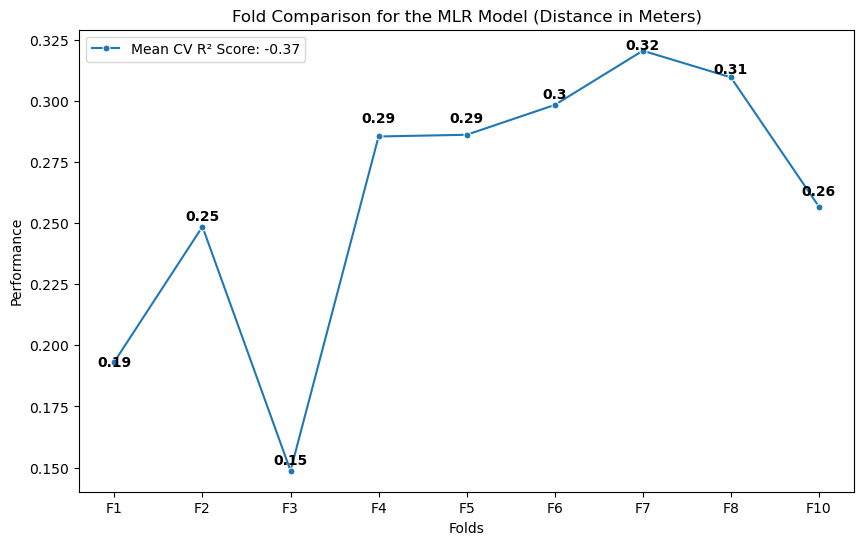

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['lines.markersize'] = 5

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="Fold", y="Score", marker="o")
plt.xlabel('Folds')
plt.ylabel('Performance')
plt.title('Fold Comparison for the MLR Model (Distance in Meters)')
plt.legend(markerscale=10)

palette = ['black', 'black', 'black', 'black', 'black','black', 'black', 'black', 'black', 'black']

for line in range(0,df.shape[0]):
     plt.text(df.Fold[line], df.mark_value[line], df.mark_value[line], horizontalalignment='center', verticalalignment ='bottom', size='medium', color='black', weight='semibold')

plt.legend(labels=['Mean CV R² Score: -0.37'])
plt.show()

In [26]:
import statsmodels.api as sm
x = sm.add_constant(transformed_df)
y = list(Atlanta_Distance['current_listing_price'])
model= sm.OLS(y, x)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])
results = model.fit()
results.model.data.xnames = ['const'] + all_feature_names
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     642.3
Date:                Mon, 14 Oct 2024   Prob (F-statistic):               0.00
Time:                        21:40:28   Log-Likelihood:            -1.7012e+05
No. Observations:               21030   AIC:                         3.403e+05
Df Residuals:                   21018   BIC:                         3.404e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             2272.0433      5.440  